In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
tfkl = tfk.layers
import matplotlib.pyplot as plt

# **1. Autoencoder**

In [3]:
data,info=tfds.load('cifar10',with_info=True)
print(info)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteWH1EFO/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteWH1EFO/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    

In [4]:
preprocess = lambda d: (tf.cast(d['image'],tf.float32)/255., d['label'])
ae_targets = lambda x,y : (x,x)
ds_train = \
   data['train'] \
   .map(preprocess) \
   .map(ae_targets) \
   .cache() \
   .batch(32) \
   .repeat() \
   .prefetch(5)
ds_test = data["test"].map(preprocess)

In [5]:
img_shape = info.features['image'].shape
print(img_shape)

(32, 32, 3)


In [6]:
encoder=tfk.Sequential([tfkl.Conv2D(filters=64,kernel_size=3,strides=1,padding="same",activation='relu',input_shape=(32,32,3)),
            tfkl.MaxPool2D(pool_size=2,padding="same"),

            tfkl.Conv2D(filters=32,kernel_size=3,strides=1,padding="same",activation='relu'),
            tfkl.MaxPool2D(pool_size=2,padding="same"),

            tfkl.Conv2D(filters=16,kernel_size=3,strides=1,padding="same", activation='relu'),
            tfkl.MaxPool2D(pool_size=2,padding="same")  
            ])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
Total params: 24,880
Trainable params: 24,880
Non-trainable params: 0
____________________________________________________

In [7]:
decoder=tfk.Sequential([tfkl.Conv2D(filters=16,kernel_size=3,strides=1,padding="same",activation='relu',input_shape=(4,4,16)),
            tfkl.UpSampling2D((2,2)),
            tfkl.Conv2D(filters=32,kernel_size=3,strides=1,padding="same",activation='relu'),
            tfkl.UpSampling2D((2,2)),
            tfkl.Conv2D(filters=64,kernel_size=3,strides=1,padding="same",activation='relu'),
            tfkl.UpSampling2D((2,2)),
            tfkl.Conv2D(filters=3,kernel_size=3,activation='sigmoid',padding="same")
            ])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 4, 4, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 3)        

In [8]:
# the tf.keras function API starts with defining placeholder tensors that represent model inputs
x = tfkl.Input(img_shape)

# we can then pass this placeholder through our models to specify the computation to get a prediction
h = encoder(x)
xhat = decoder(h)

# finally we use the tfk.Model class instantiate the model by specifying the inputs and outputs
# (note: this can also be lists, which is how you make more complex models with multiple inputs and/or outputs)
autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

# training happens as usual
autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
)

results = autoencoder.fit(ds_train, steps_per_epoch=100, epochs=10)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 4, 4, 16)          24880     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         27187     
Total params: 52,067
Trainable params: 52,067
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 20s 203ms/step - loss: 0.6334
Epoch 2/10
100/100 [==============================] - 20s 195ms/step - loss: 0.5970
Epoch 3/10
100/100 [==============================] - 20s 199ms/step - loss: 0.5899
Epoch 4/10
100/100 [==============================] - 20s 200ms/step - loss: 0.5839
Epoch 5/10
100/100 [========================

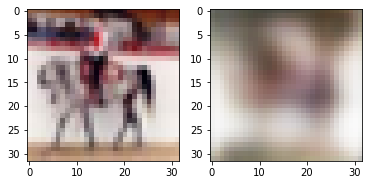

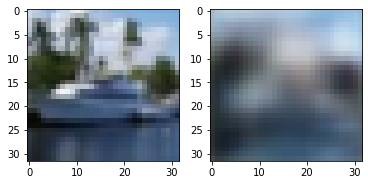

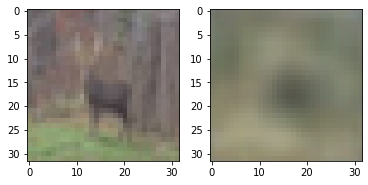

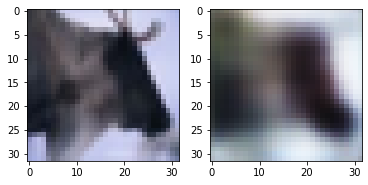

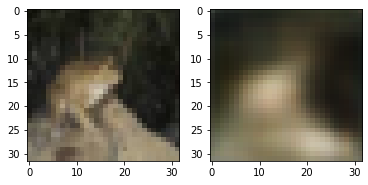

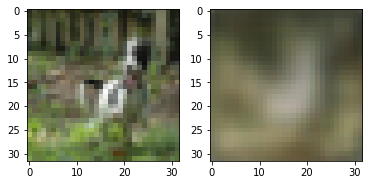

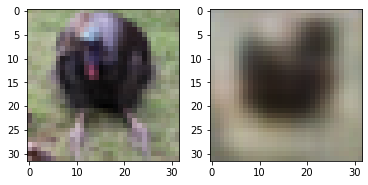

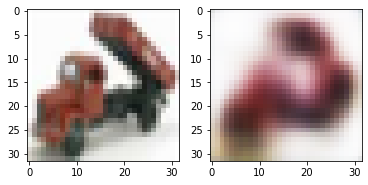

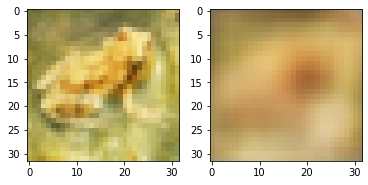

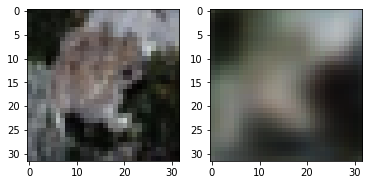

In [9]:
imgs = next(iter(ds_train))[0]
for i in range(10):
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
    plt.subplot(1, 2, 2, )
    plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
    plt.show()

# **2. Image Classification**

**2.1 Deep CNN**

In [10]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))
ds_train = data["train"].map(preprocess).cache().batch(32)
ds_test = data["test"].map(preprocess).cache().batch(32)

In [11]:
model = tfk.Sequential()
# block1
model.add(tfkl.Conv2D(filters = 32, kernel_size=3, strides=1, padding="valid", activation='relu', input_shape=(32, 32, 3)))
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))


# block2
model.add(tfkl.Conv2D(filters = 16, kernel_size=3, strides=1, padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

# block3
model.add(tfkl.Conv2D(filters = 8, kernel_size=3, strides=1, padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

# flatten
model.add(tfkl.GlobalMaxPool2D())
model.add(tfkl.Dense(10, activation = 'softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 8)          

In [12]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

results = model.fit(ds_train, batch_size=100, epochs=10, validation_data = ds_test)

Epoch 1/10
1563/1563 [==============================] - 70s 45ms/step - loss: 1.9727 - val_loss: 2.0503
Epoch 2/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.7369 - val_loss: 1.7836
Epoch 3/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.6478 - val_loss: 1.7674
Epoch 4/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.5925 - val_loss: 1.7105
Epoch 5/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.5544 - val_loss: 1.6055
Epoch 6/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.5257 - val_loss: 1.5907
Epoch 7/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.5016 - val_loss: 1.5210
Epoch 8/10
1563/1563 [==============================] - 54s 35ms/step - loss: 1.4792 - val_loss: 1.5083
Epoch 9/10
1563/1563 [==============================] - 53s 34ms/step - loss: 1.4645 - val_loss: 1.5776
Epoch 10/10
1563/1563 [==============================] - 52s 33m

Text(0.5, 1.0, 'Loss')

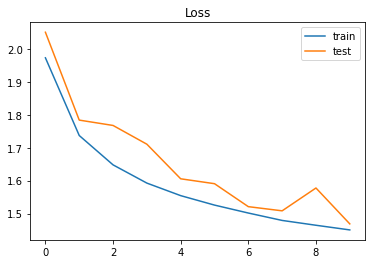

In [13]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "test"])
plt.title('Loss')

**2.2 Transfer Learning**

In [14]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(32,32,3))
transfer=tfk.Sequential()
transfer.add(conv_base)
transfer.add(tfkl.GlobalMaxPool2D())
transfer.add(tfkl.Dense(10, activation = 'softmax'))

In [15]:
transfer.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy()
)
conv_base.trainable = False
results2 = transfer.fit(ds_train, batch_size=100, epochs=5, validation_data = ds_test)

Epoch 1/5
1563/1563 [==============================] - 4070s 3s/step - loss: 4.1382 - val_loss: 2.3027
Epoch 2/5
1563/1563 [==============================] - 4268s 3s/step - loss: 2.3028 - val_loss: 2.3027
Epoch 3/5
1563/1563 [==============================] - 4169s 3s/step - loss: 2.3028 - val_loss: 2.3027
Epoch 4/5
1563/1563 [==============================] - 4250s 3s/step - loss: 2.3028 - val_loss: 2.3027
Epoch 5/5
1563/1563 [==============================] - 4023s 3s/step - loss: 2.3028 - val_loss: 2.3027


Text(0.5, 1.0, 'Loss')

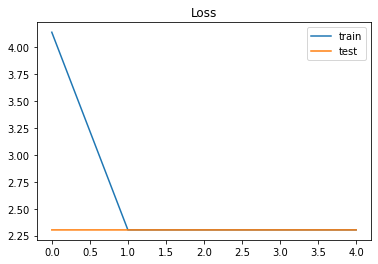

In [16]:
plt.plot(results2.history["loss"])
plt.plot(results2.history["val_loss"])
plt.legend(labels=["train", "test"])
plt.title('Loss')

# **3. Text Classification**

In [17]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive/', force_remount=True)
file_path = "/content/gdrive/My Drive/SPAM_detection.csv"

df = pd.read_csv(file_path)

Mounted at /content/gdrive/


In [18]:
df.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [19]:
X = np.asarray(df["Message"])
y = df['category_val'].values
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, padding='post', maxlen=50)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**3.1 RNN**

In [20]:
max_words = 10000
embedding_dim=32
lstm=tfk.Sequential()
lstm.add(tfkl.Embedding(max_words,embedding_dim, input_shape=(50,)))
lstm.add(tfkl.LSTM(32))
lstm.add(tfkl.Dropout(0.2))

lstm.add(tfkl.Dense(1,activation="sigmoid"))
lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [21]:
lstm.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.01),metrics=["accuracy"])
results3 = lstm.fit(X_train, y_train, batch_size=100, epochs=10, validation_data = (X_test, y_test))


Epoch 1/10
39/39 [==============================] - 2s 41ms/step - loss: 0.2715 - accuracy: 0.9013 - val_loss: 0.1784 - val_accuracy: 0.9563
Epoch 2/10
39/39 [==============================] - 1s 28ms/step - loss: 0.1475 - accuracy: 0.9656 - val_loss: 0.2352 - val_accuracy: 0.9444
Epoch 3/10
39/39 [==============================] - 1s 26ms/step - loss: 0.1088 - accuracy: 0.9785 - val_loss: 0.1881 - val_accuracy: 0.9617
Epoch 4/10
39/39 [==============================] - 1s 28ms/step - loss: 0.0652 - accuracy: 0.9867 - val_loss: 0.1377 - val_accuracy: 0.9707
Epoch 5/10
39/39 [==============================] - 1s 26ms/step - loss: 0.0469 - accuracy: 0.9910 - val_loss: 0.1722 - val_accuracy: 0.9569
Epoch 6/10
39/39 [==============================] - 1s 26ms/step - loss: 0.0696 - accuracy: 0.9864 - val_loss: 0.1437 - val_accuracy: 0.9641
Epoch 7/10
39/39 [==============================] - 1s 26ms/step - loss: 0.0826 - accuracy: 0.9723 - val_loss: 0.1882 - val_accuracy: 0.9468
Epoch 8/10
39

Text(0.5, 1.0, 'Loss')

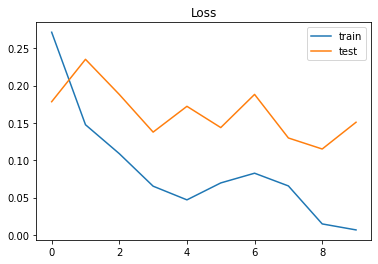

In [22]:
plt.plot(results3.history["loss"])
plt.plot(results3.history["val_loss"])
plt.legend(labels=["train", "test"])
plt.title('Loss')

**3.2 CNN**

In [23]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
import re
def clean_text(text, remove_stopwords=False):
    text = re.sub(r'https?:\/\/.+$', ' ',text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    if remove_stopwords:
        words = [w for w in words if w not in eng_stopwords]
    return words
words = [clean_text(text,True) for text in list(df["Message"])]

In [25]:
import gensim
from gensim.models.word2vec import Word2Vec
word2vec_model = Word2Vec(words, min_count=1, size= 50,workers=3, window =3, sg = 1)

In [26]:
max_len=max([len(word) for word in words])
sentence_matrix = []
for sentence in words:
  one_sentence = []
  for word in sentence:
    word_matrix = word2vec_model.wv[word]
    one_sentence.append(word_matrix)
  more = max_len - len(one_sentence)
  one_sentence = one_sentence + [[0]*50]*more
  one_sentence = np.asarray(one_sentence)
  sentence_matrix.append(one_sentence)
sentence_matrix = np.asarray(sentence_matrix)

In [27]:
y = df['category_val'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(sentence_matrix, y, test_size = 0.3)


In [28]:
cnn = tfk.Sequential()
# block1
cnn.add(tfkl.Conv1D(filters=32,kernel_size=3,strides=1,
                    padding="same",activation='relu',input_shape=X_train2[1].shape))
cnn.add(tfkl.MaxPool1D(pool_size=2))
cnn.add(tfkl.Dropout(.2))


# block2
cnn.add(tfkl.Conv1D(filters = 16, kernel_size=3, strides=1, padding="same", activation='relu'))
cnn.add(tfkl.MaxPool1D(pool_size=2))
cnn.add(tfkl.Dropout(.2))

# block3
cnn.add(tfkl.Conv1D(filters = 8, kernel_size=3, strides=1, padding="same", activation='relu'))
cnn.add(tfkl.MaxPool1D(pool_size=2))
cnn.add(tfkl.Dropout(.2))

# flatten
cnn.add(tfkl.Flatten())
cnn.add(tfkl.Dense(1, activation = 'sigmoid'))


cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 77, 32)            4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 32)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 38, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 38, 16)            1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 8)            

In [29]:
cnn.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.01),metrics=["accuracy"])
results4 = cnn.fit(X_train2, y_train2, batch_size=100, epochs=10,shuffle=True, validation_data = (X_test2, y_test2))


Epoch 1/10
39/39 [==============================] - 1s 25ms/step - loss: 0.3569 - accuracy: 0.8526 - val_loss: 0.2930 - val_accuracy: 0.8786
Epoch 2/10
39/39 [==============================] - 1s 20ms/step - loss: 0.2383 - accuracy: 0.9051 - val_loss: 0.7751 - val_accuracy: 0.7183
Epoch 3/10
39/39 [==============================] - 1s 20ms/step - loss: 0.1773 - accuracy: 0.9395 - val_loss: 0.1254 - val_accuracy: 0.9569
Epoch 4/10
39/39 [==============================] - 1s 22ms/step - loss: 0.1527 - accuracy: 0.9485 - val_loss: 0.1028 - val_accuracy: 0.9701
Epoch 5/10
39/39 [==============================] - 1s 21ms/step - loss: 0.1436 - accuracy: 0.9574 - val_loss: 0.0968 - val_accuracy: 0.9707
Epoch 6/10
39/39 [==============================] - 1s 21ms/step - loss: 0.1304 - accuracy: 0.9577 - val_loss: 0.1097 - val_accuracy: 0.9665
Epoch 7/10
39/39 [==============================] - 1s 20ms/step - loss: 0.1232 - accuracy: 0.9572 - val_loss: 0.1287 - val_accuracy: 0.9539
Epoch 8/10
39

Text(0.5, 1.0, 'Loss')

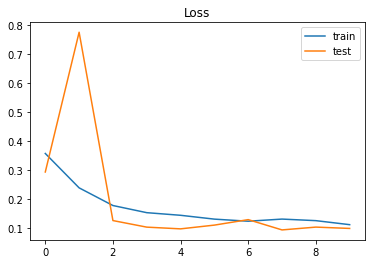

In [30]:
plt.plot(results4.history["loss"])
plt.plot(results4.history["val_loss"])
plt.legend(labels=["train", "test"])
plt.title('Loss')

**3.3 Comparision**

In [31]:
lstm_pre = lstm.predict(X_test)
cnn_pre= cnn.predict(X_test2)


from sklearn.metrics import roc_curve, auc
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, lstm_pre)
auc_lstm = auc(fpr_lstm, tpr_lstm)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test2, cnn_pre)
auc_cnn = auc(fpr_cnn, tpr_cnn)

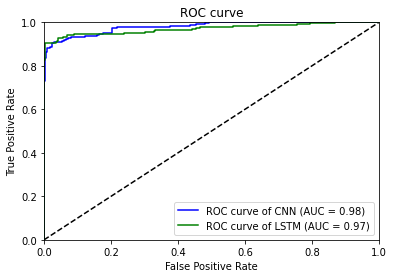

In [32]:
plt.title("ROC curve")
plt.plot([0,1], [0,1],'k--')
plt.plot(fpr_cnn, tpr_cnn, 'b', label = 'ROC curve of CNN (AUC = %0.2f)' % auc_cnn)
plt.plot(fpr_lstm, tpr_lstm,'g',label= 'ROC curve of LSTM (AUC = %0.2f)' %auc_lstm)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()